# **Feature Engineering**

## Objectives

* Assess target imbalance and decide how to handle
* Transform the data to prepare for the classification model

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* List of feature engineering steps to add to the ML pipeline



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor'

# Load Data

Load the cleaned train set from the previous notebook

In [5]:
import pandas as pd
train_set_df = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")
train_set_df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70,M,ASY,140.0,213.0,high diabetes risk,Normal,157,Y,2.0,Flat,1
1,46,M,ASY,115.0,230.0,low diabetes risk,Normal,113,Y,1.5,Flat,1
2,65,F,NAP,160.0,360.0,low diabetes risk,LVH,151,N,0.8,Up,0


Load the cleaned test set from the previous notebook

In [6]:
test_set_df = pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv")
test_set_df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,M,ASY,115.0,248.0,high diabetes risk,Normal,155,N,0.1,Flat,1
1,66,M,ASY,120.0,302.0,low diabetes risk,LVH,151,N,0.4,Flat,0
2,51,M,ASY,110.0,279.0,high diabetes risk,Normal,92,N,0.0,Flat,1


---

# Target Imbalance

In order to ensure the classification model doesn't overfit or underfit the data, the train set needs to be assessed for target imbalance.

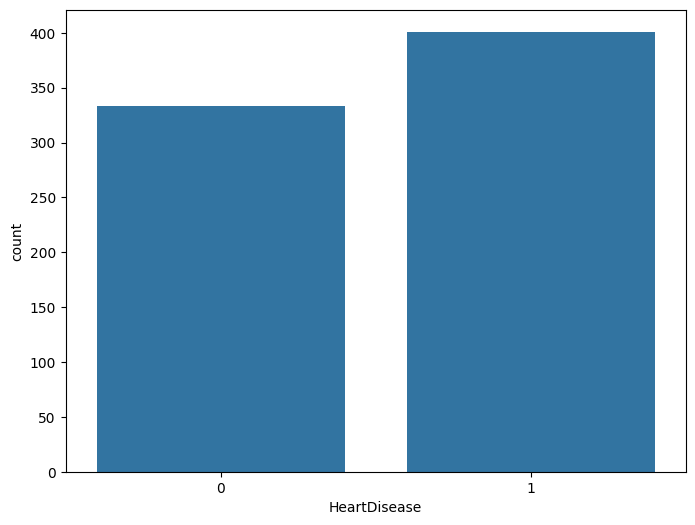

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x=train_set_df["HeartDisease"])
plt.show()

In [8]:
train_set_df["HeartDisease"].replace({0: "No disease", 1: "Heart Disease"}).value_counts()

HeartDisease
Heart Disease    401
No disease       333
Name: count, dtype: int64

From this, we can see there is a very slight imbalance in the data with more observations of heart disease (target = 1).

At this stage it was decided to continue without any balancing in order to retain the original dataset, with the aim to revisit if the model overfits.

---

## Discretisation of Oldpeak Feature

From the EDA, it was found that the Oldpeak feature was heavily imbalanced with a very high quantity of zero values. It was therefore decided that the best plan of action was to discretise the numerical data into categories.

In [9]:
import numpy as np
from feature_engine.discretisation import ArbitraryDiscretiser
from sklearn.pipeline import Pipeline

map_dict = {0: "≤ 0", 1: "0 ≤ 1.5", 2: "> 1.5"}

pipeline = Pipeline([
    ( 'arbd', ArbitraryDiscretiser(binning_dict={'Oldpeak':[-np.inf, 0, 1.5, np.inf]}) )
])

train_set_df = pipeline.fit_transform(train_set_df)
train_set_df["Oldpeak"] = train_set_df["Oldpeak"].replace(to_replace=map_dict)
train_set_df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70,M,ASY,140.0,213.0,high diabetes risk,Normal,157,Y,> 1.5,Flat,1
1,46,M,ASY,115.0,230.0,low diabetes risk,Normal,113,Y,0 ≤ 1.5,Flat,1
2,65,F,NAP,160.0,360.0,low diabetes risk,LVH,151,N,0 ≤ 1.5,Up,0


In [10]:
test_set_df = pipeline.fit_transform(test_set_df)
test_set_df["Oldpeak"] = test_set_df["Oldpeak"].replace(to_replace=map_dict)
test_set_df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,M,ASY,115.0,248.0,high diabetes risk,Normal,155,N,0 ≤ 1.5,Flat,1
1,66,M,ASY,120.0,302.0,low diabetes risk,LVH,151,N,0 ≤ 1.5,Flat,0
2,51,M,ASY,110.0,279.0,high diabetes risk,Normal,92,N,≤ 0,Flat,1


---

## Feature Engineering

Load custom function provided by CodeInstitute for Feature Engineering

In [11]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Categorical Encoding

First, we select all categorical variables from the dataset.

In [12]:
categorical_variables = train_set_df.select_dtypes(include=["object"]).columns.to_list()
categorical_variables

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope']

Then we assess the variables distribution after applying the transformation to ensure the encoding method was successful.

* Variable Analyzed: Sex
* Applied transformation: ['Sex_ordinal_encoder'] 



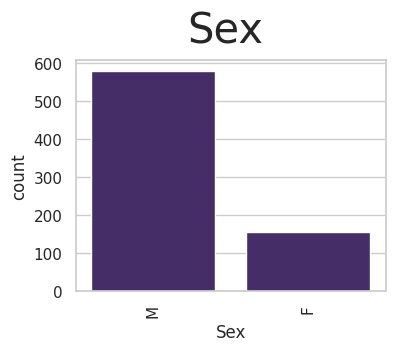

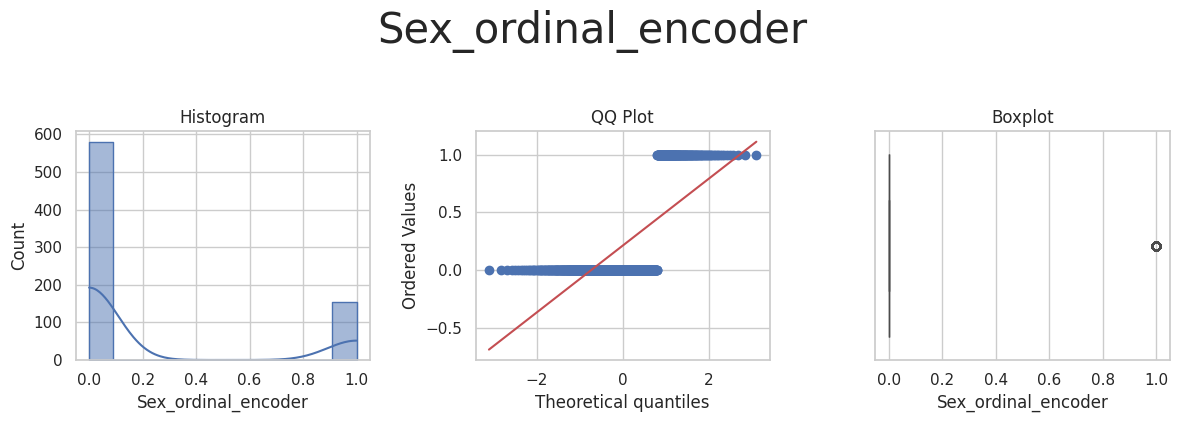



* Variable Analyzed: ChestPainType
* Applied transformation: ['ChestPainType_ordinal_encoder'] 



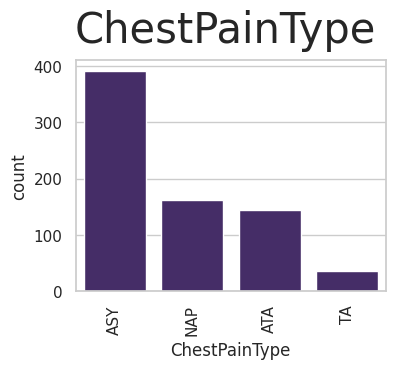

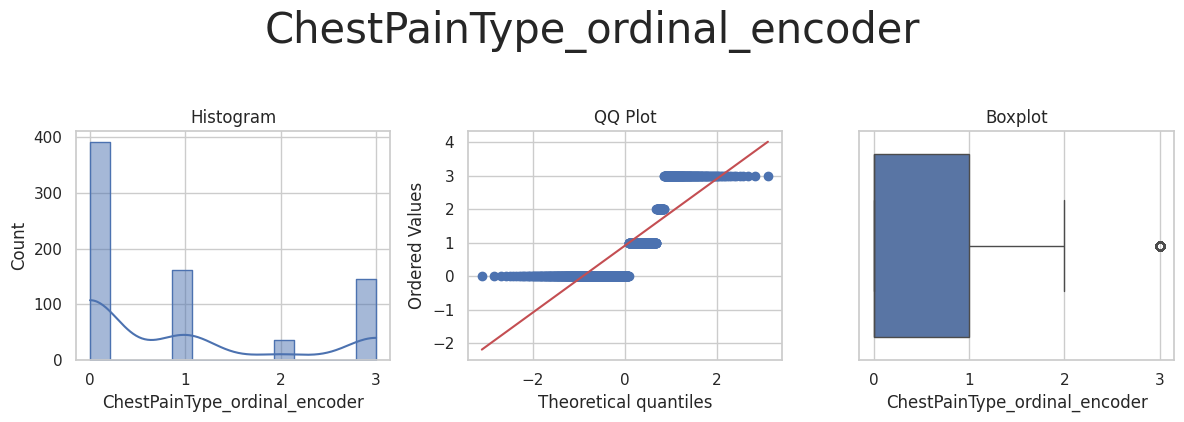



* Variable Analyzed: FastingBS
* Applied transformation: ['FastingBS_ordinal_encoder'] 



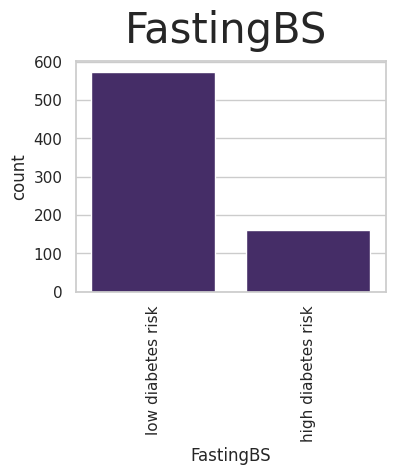

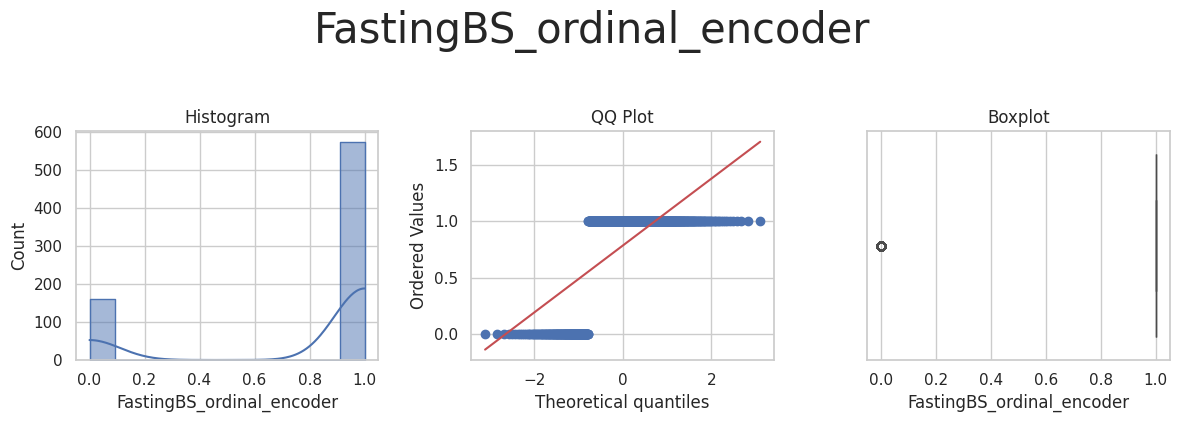



* Variable Analyzed: RestingECG
* Applied transformation: ['RestingECG_ordinal_encoder'] 



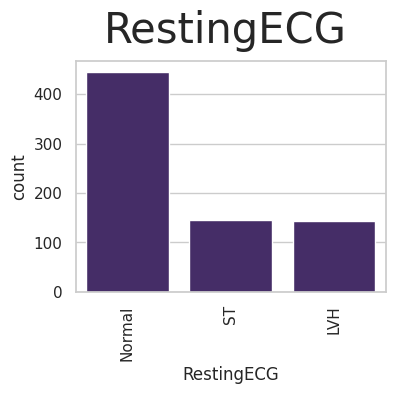

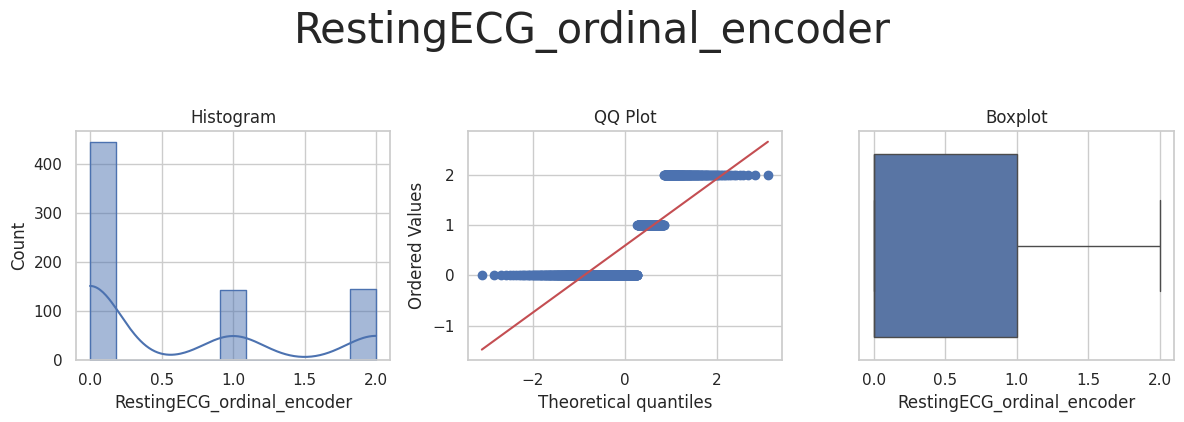



* Variable Analyzed: ExerciseAngina
* Applied transformation: ['ExerciseAngina_ordinal_encoder'] 



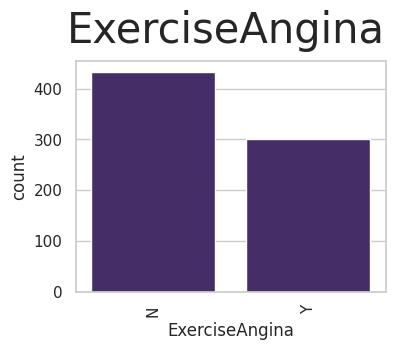

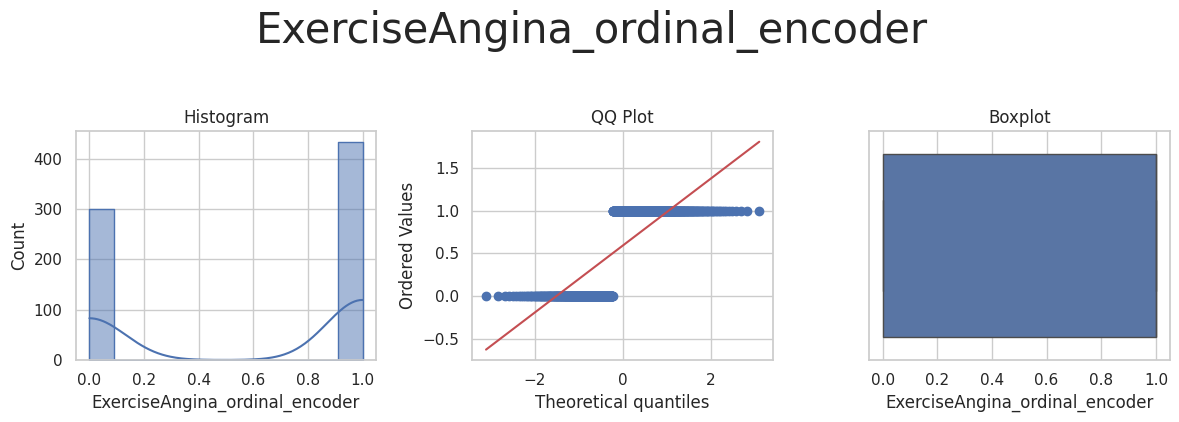



* Variable Analyzed: Oldpeak
* Applied transformation: ['Oldpeak_ordinal_encoder'] 



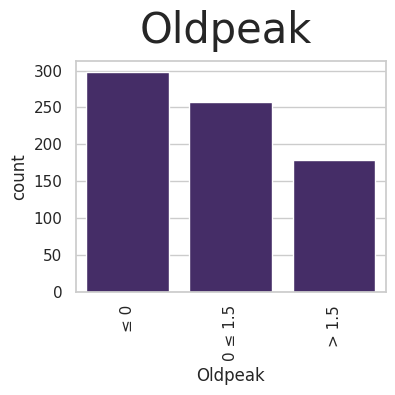

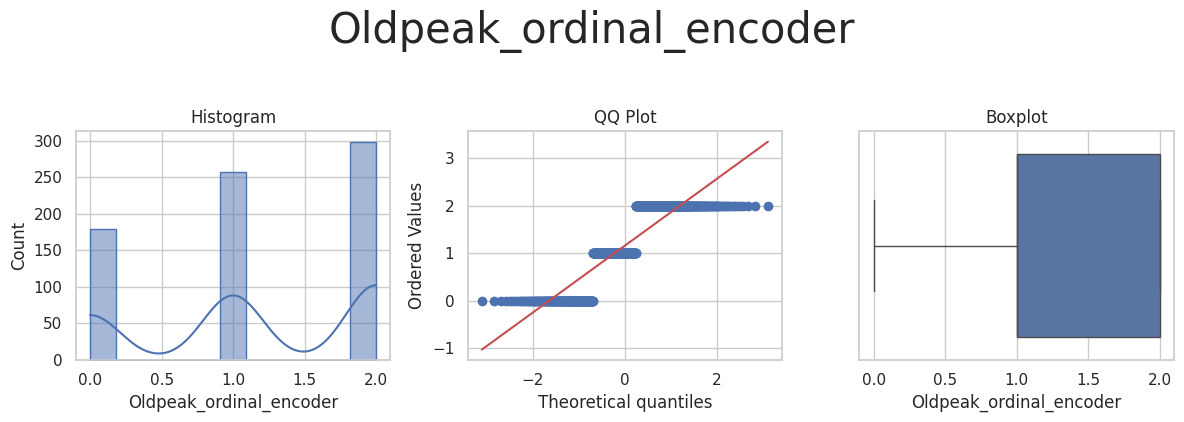



* Variable Analyzed: ST_Slope
* Applied transformation: ['ST_Slope_ordinal_encoder'] 



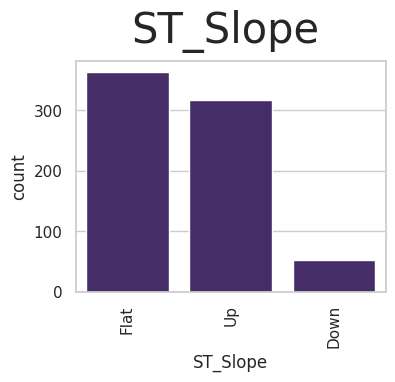

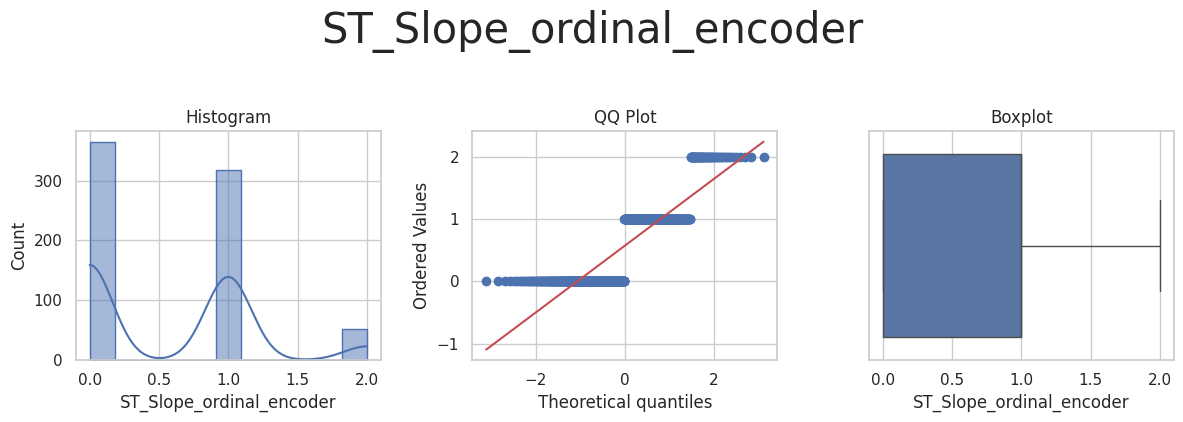

In [13]:
df_engineering = train_set_df[categorical_variables].copy()
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type="ordinal_encoder")

All transformations were applied correctly and features were succesfully encoded, so the transformation was applied to the train and test sets.

In [14]:
encoder = OrdinalEncoder(encoding_method="arbitrary", variables=categorical_variables)
train_set_df = encoder.fit_transform(train_set_df)
test_set_df = encoder.fit_transform(test_set_df)

---

## Numerical Transformation

First, we select all numerical variables from the dataset.

In [15]:
all_variables = train_set_df.drop("HeartDisease", axis=1).columns.to_list()
numerical_variables = [i for i in all_variables if i not in categorical_variables]
numerical_variables

['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

Then we assess the variables distribution after applying each transformation.

* Variable Analyzed: Age
* Applied transformation: ['Age_log_e', 'Age_log_10', 'Age_reciprocal', 'Age_power', 'Age_box_cox', 'Age_yeo_johnson'] 



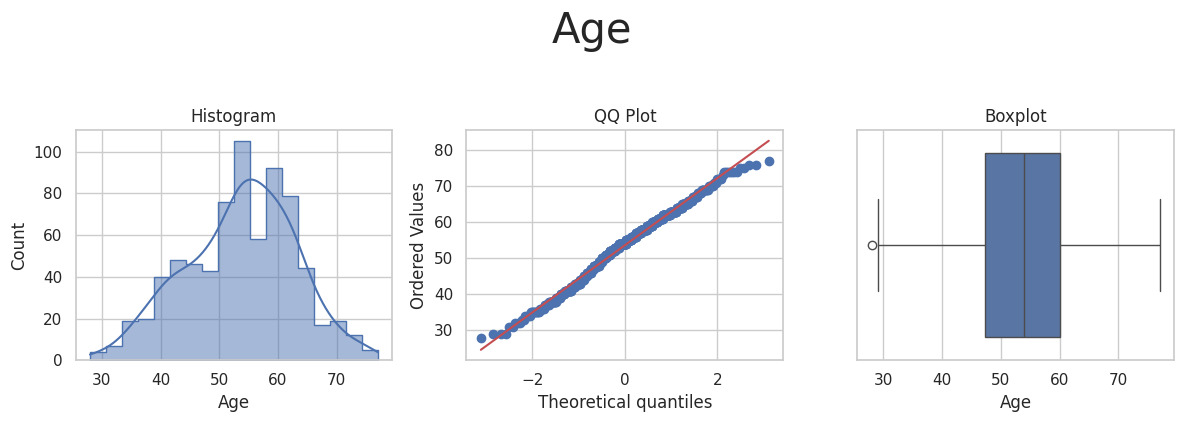

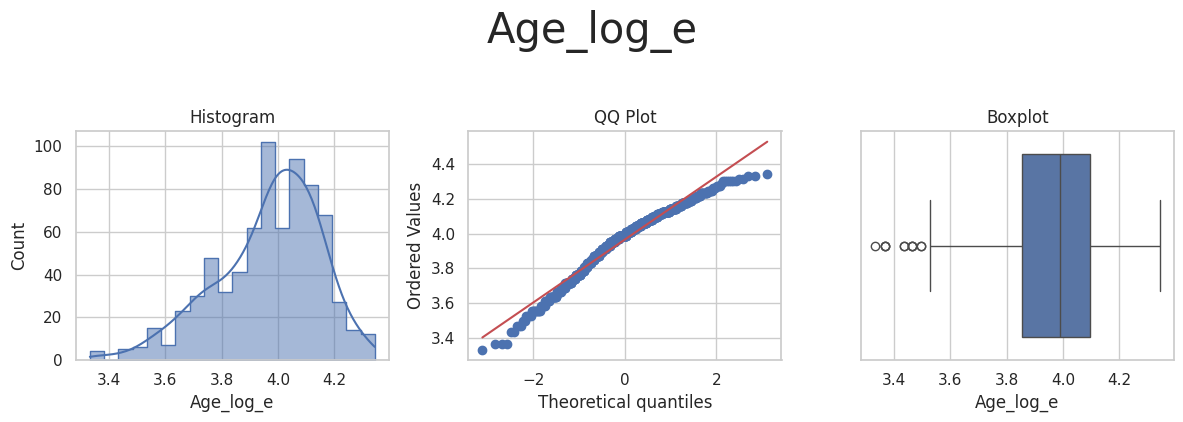

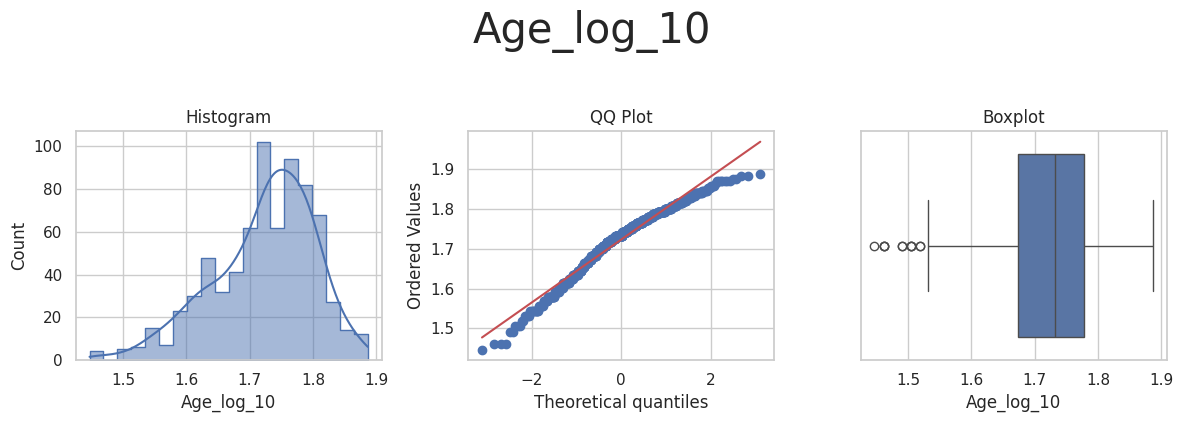

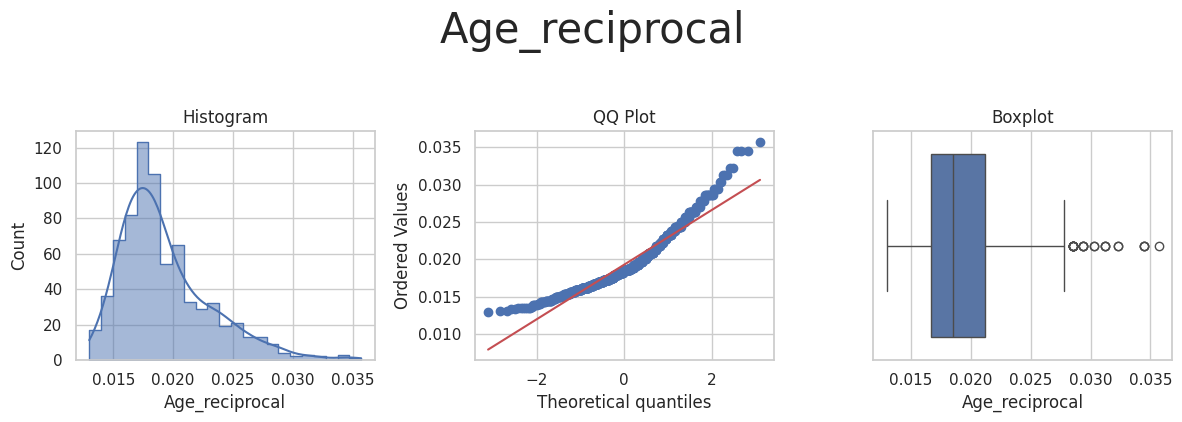

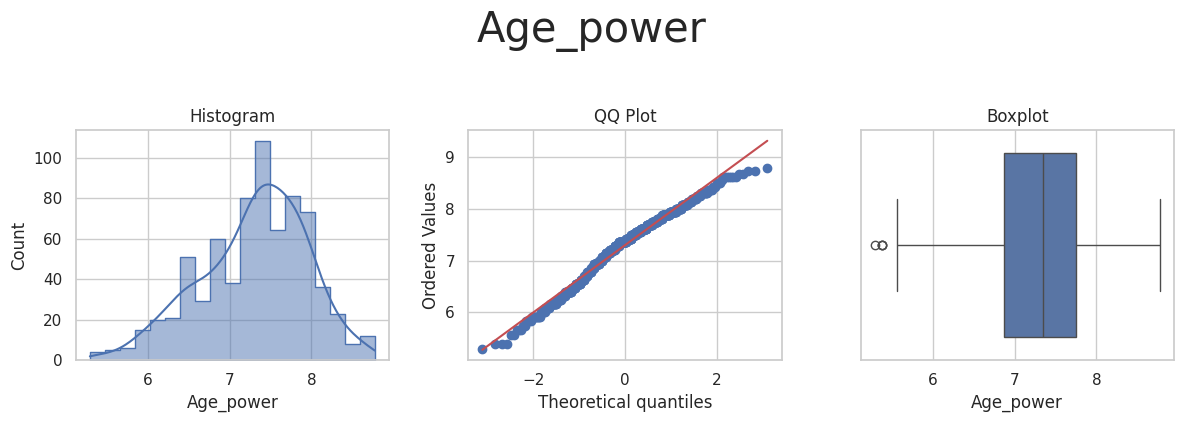

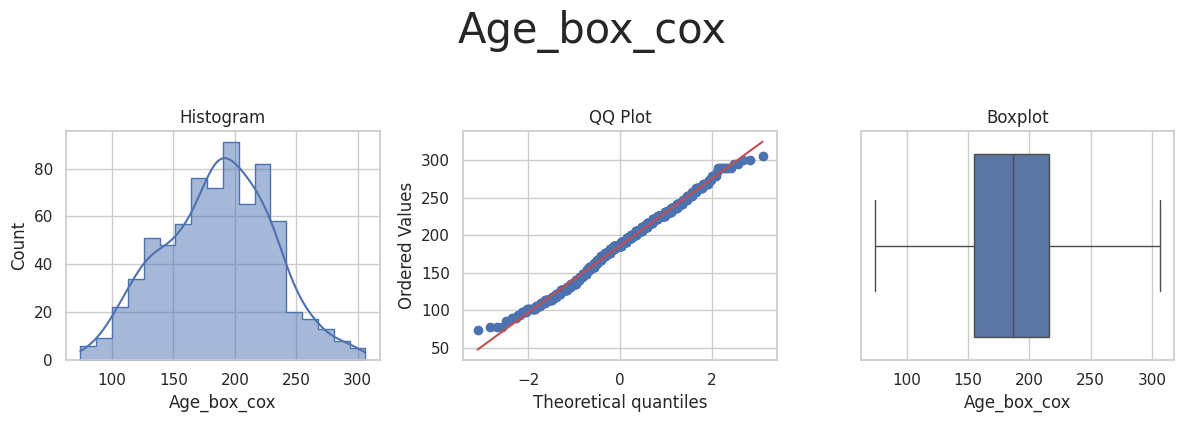

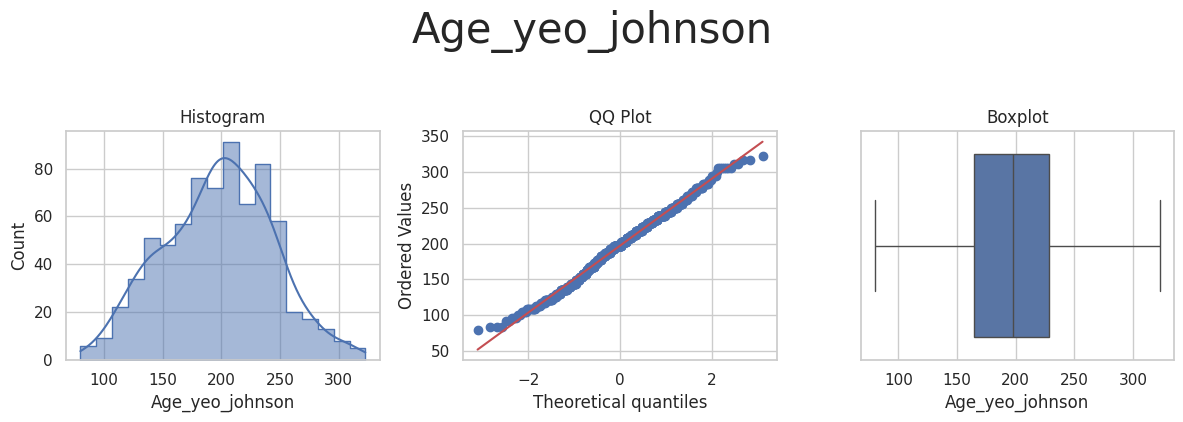



* Variable Analyzed: RestingBP
* Applied transformation: ['RestingBP_log_e', 'RestingBP_log_10', 'RestingBP_reciprocal', 'RestingBP_power', 'RestingBP_box_cox', 'RestingBP_yeo_johnson'] 



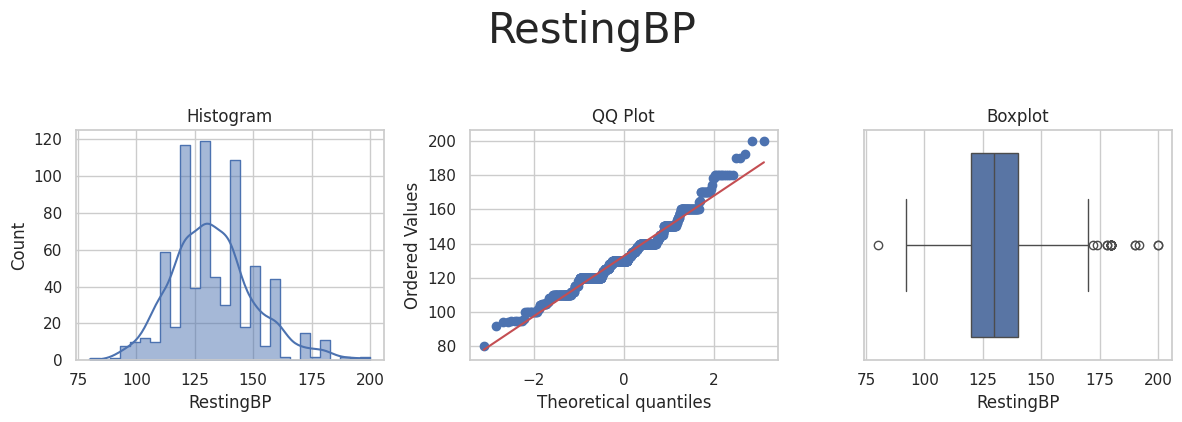

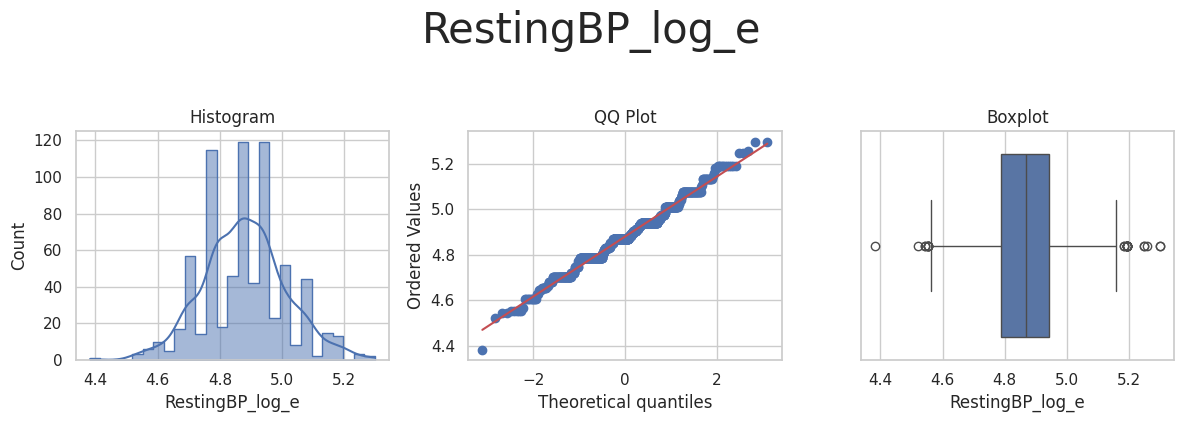

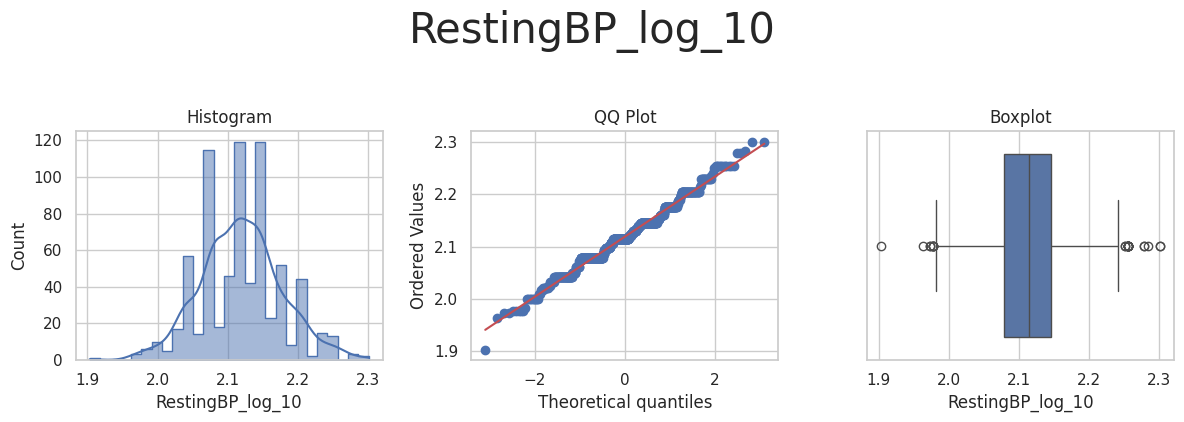

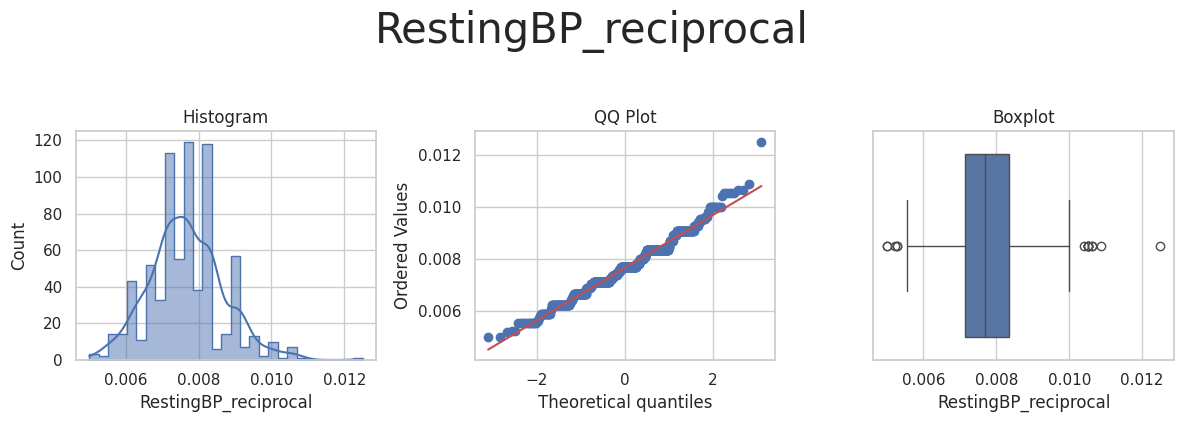

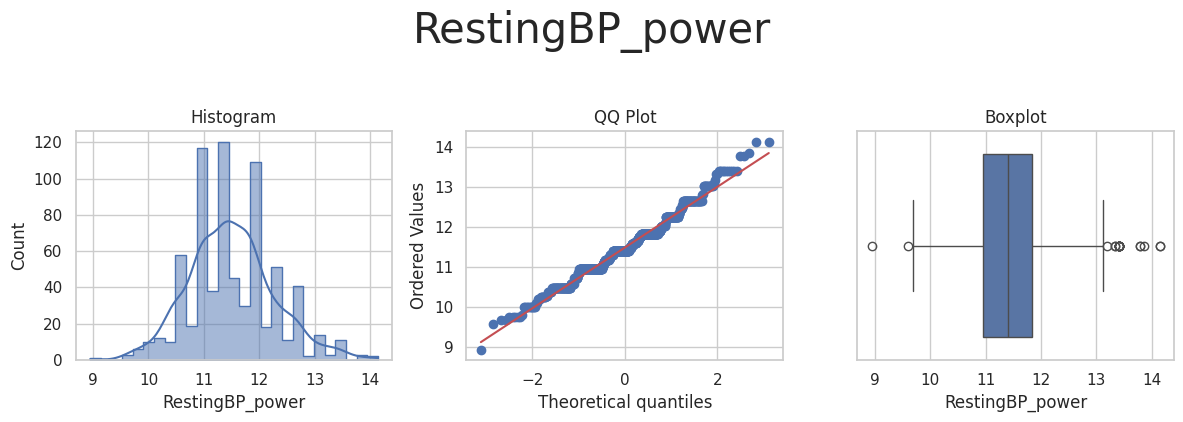

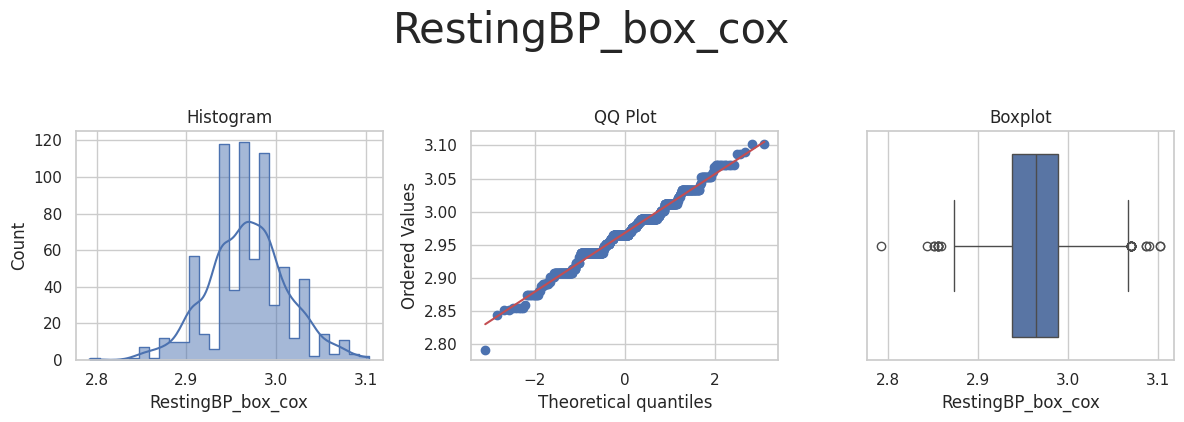

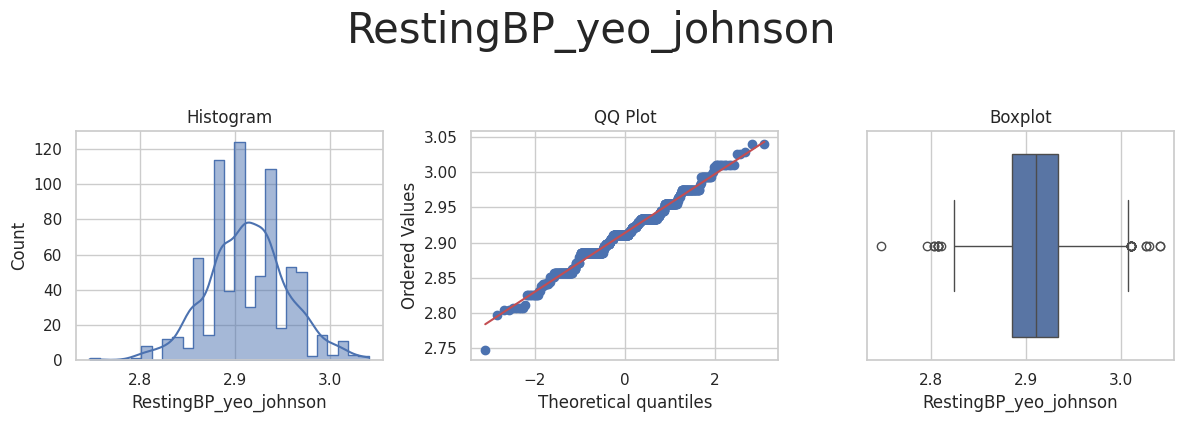



* Variable Analyzed: Cholesterol
* Applied transformation: ['Cholesterol_log_e', 'Cholesterol_log_10', 'Cholesterol_reciprocal', 'Cholesterol_power', 'Cholesterol_box_cox', 'Cholesterol_yeo_johnson'] 



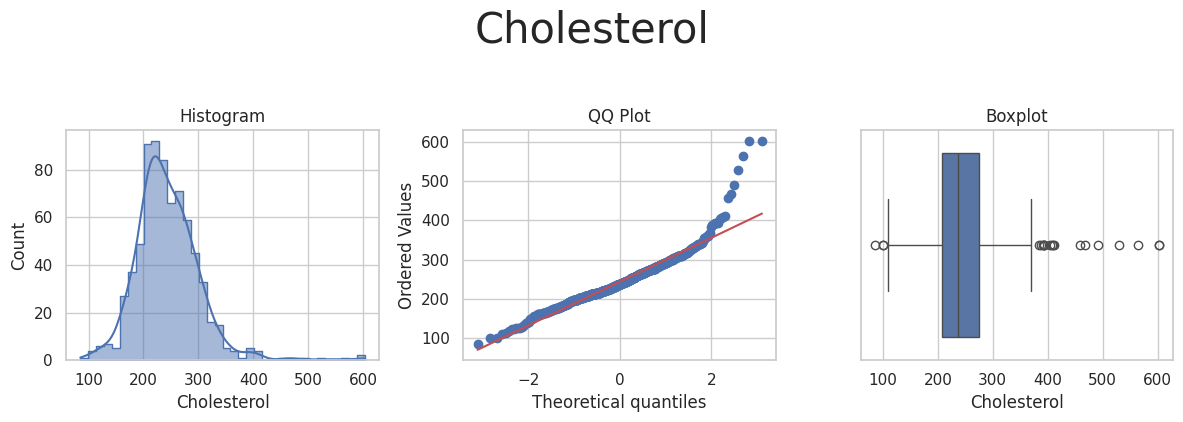

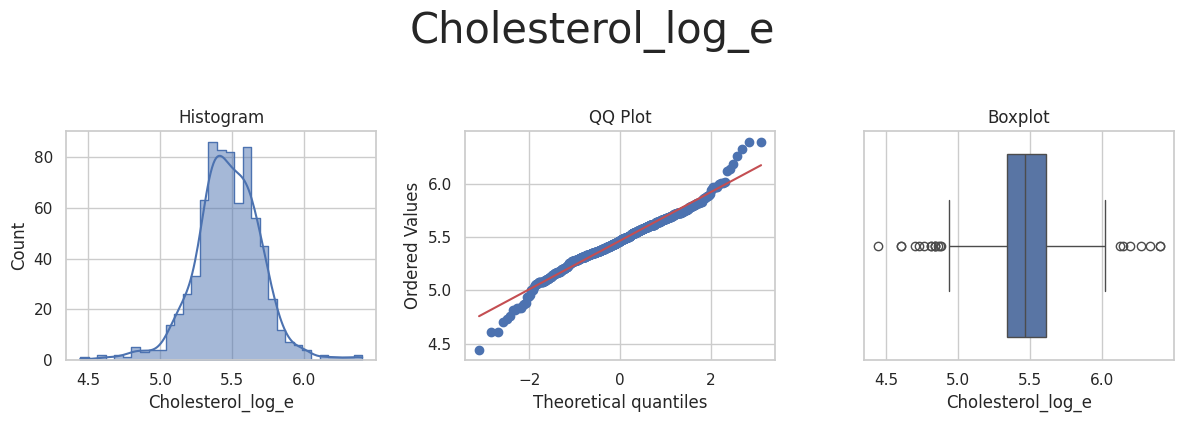

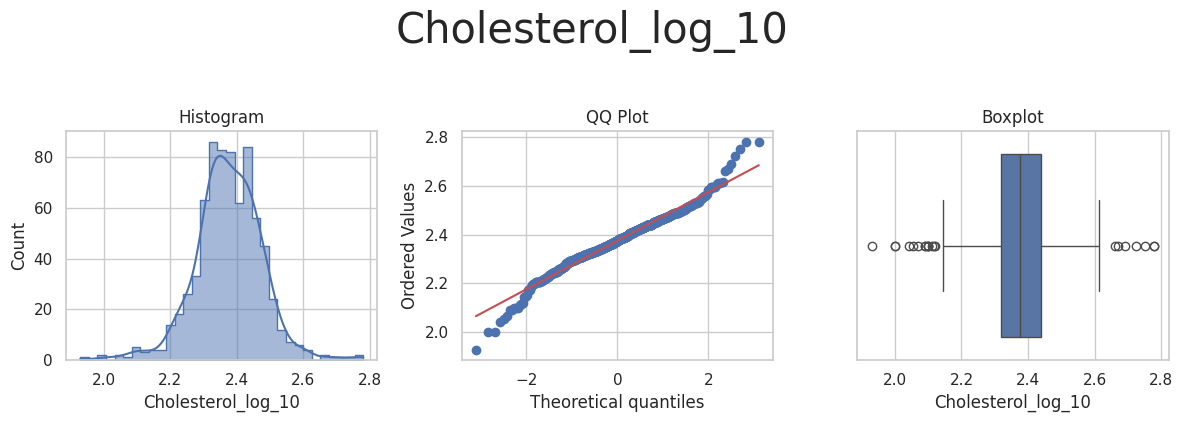

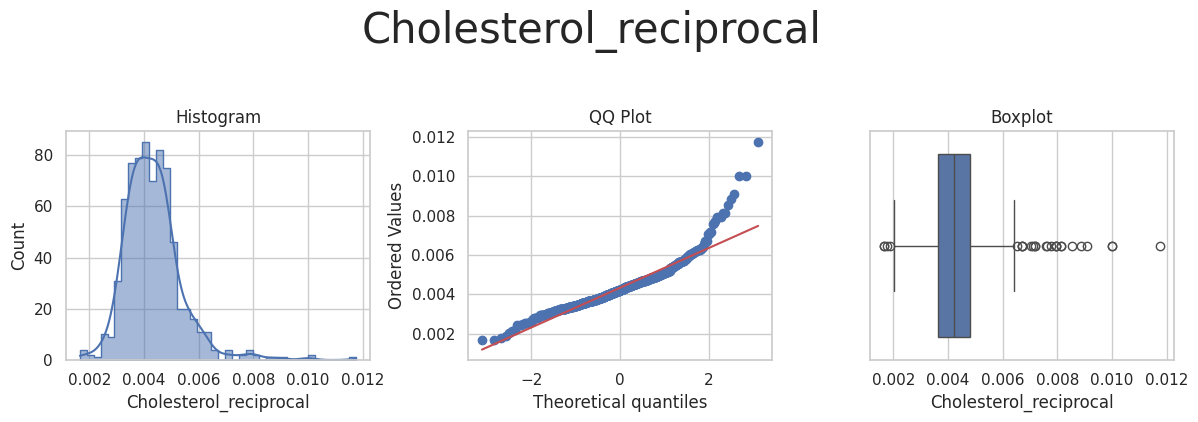

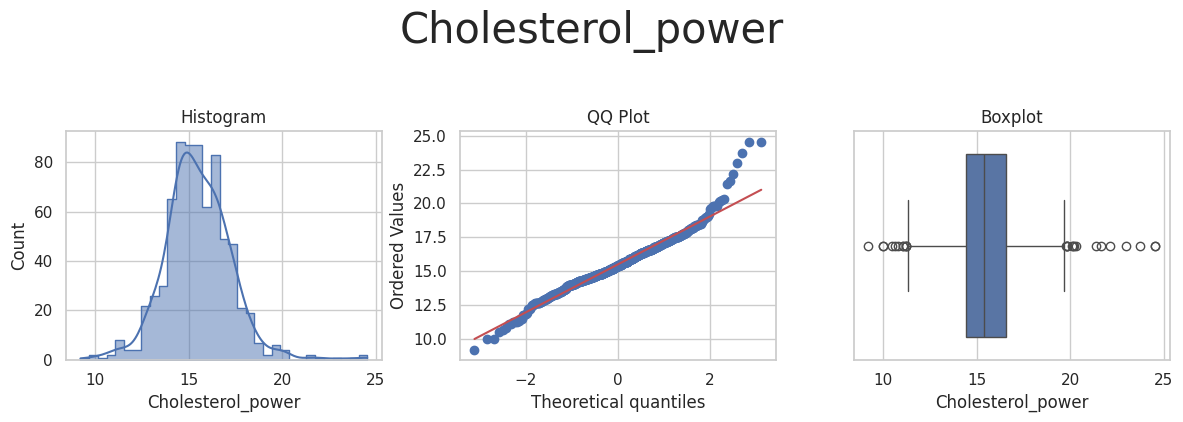

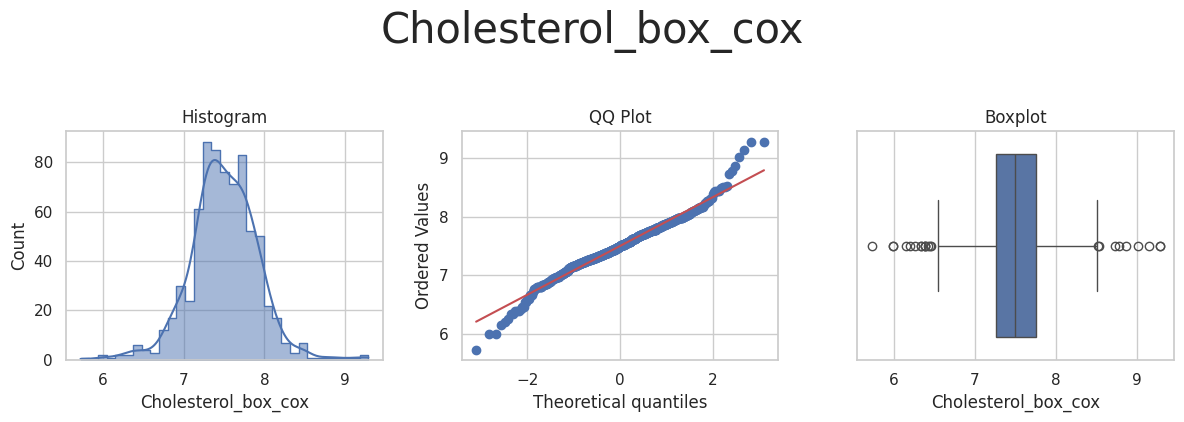

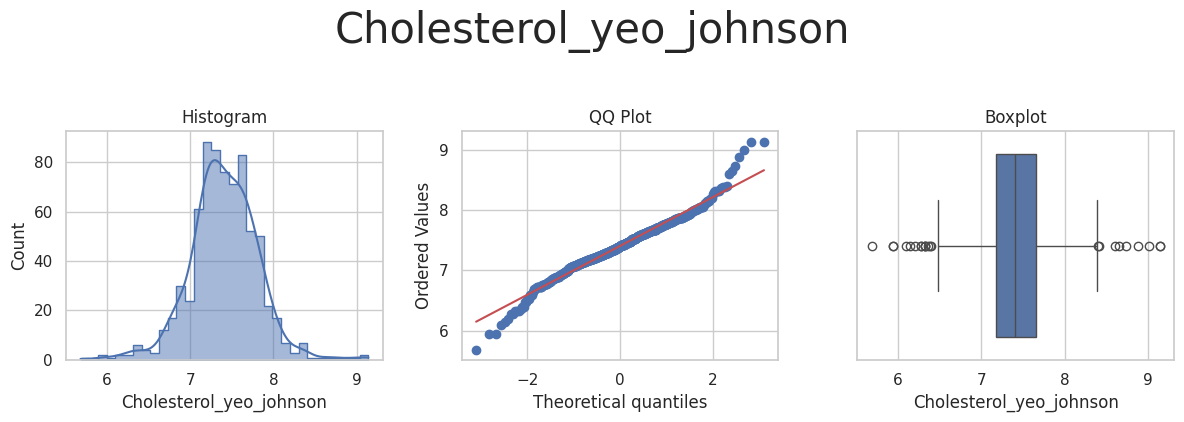



* Variable Analyzed: MaxHR
* Applied transformation: ['MaxHR_log_e', 'MaxHR_log_10', 'MaxHR_reciprocal', 'MaxHR_power', 'MaxHR_box_cox', 'MaxHR_yeo_johnson'] 



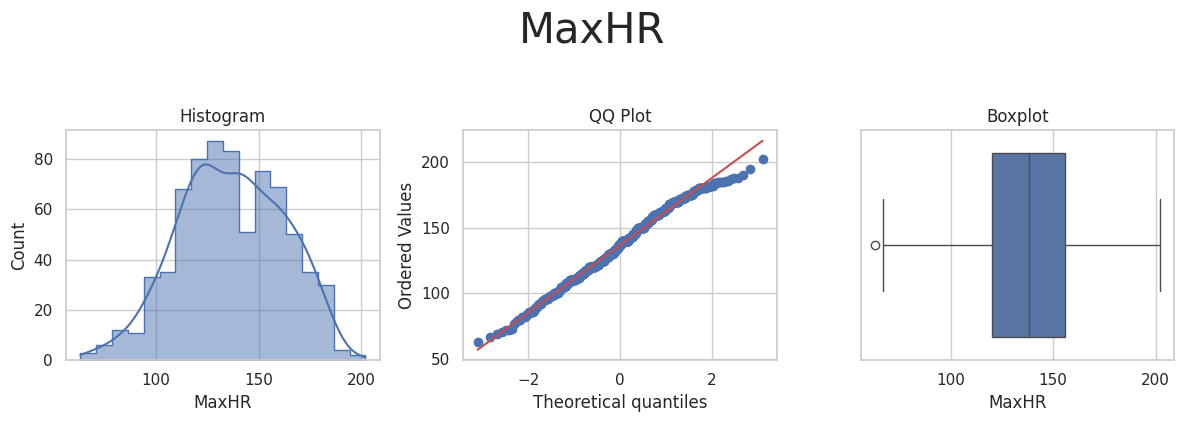

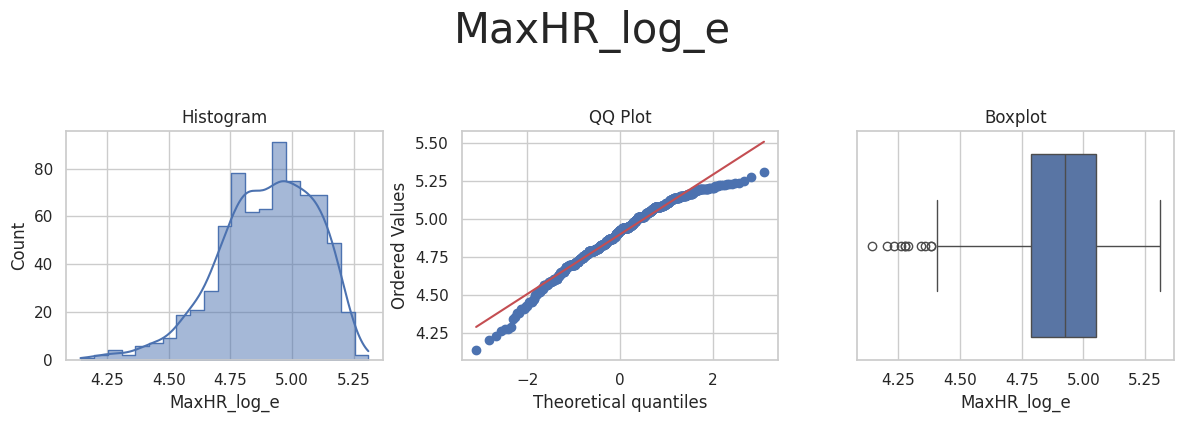

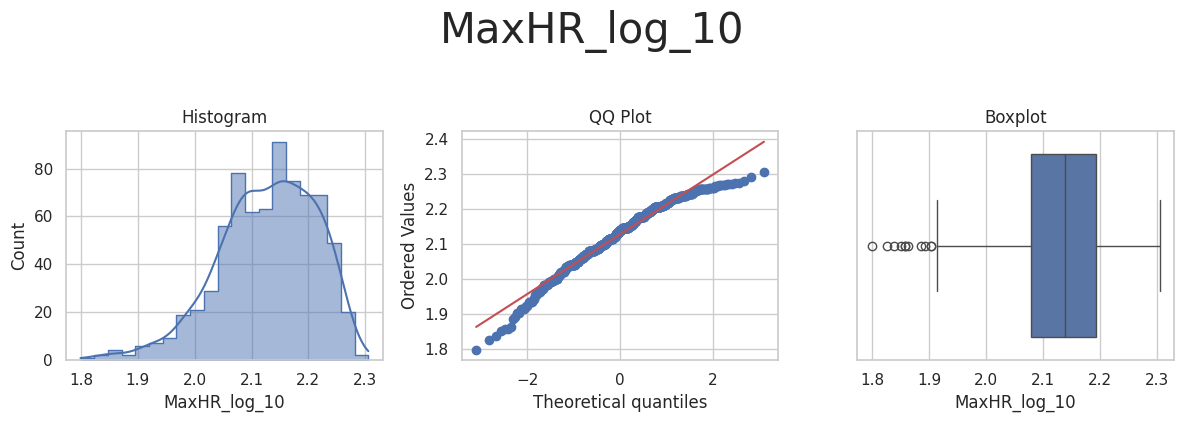

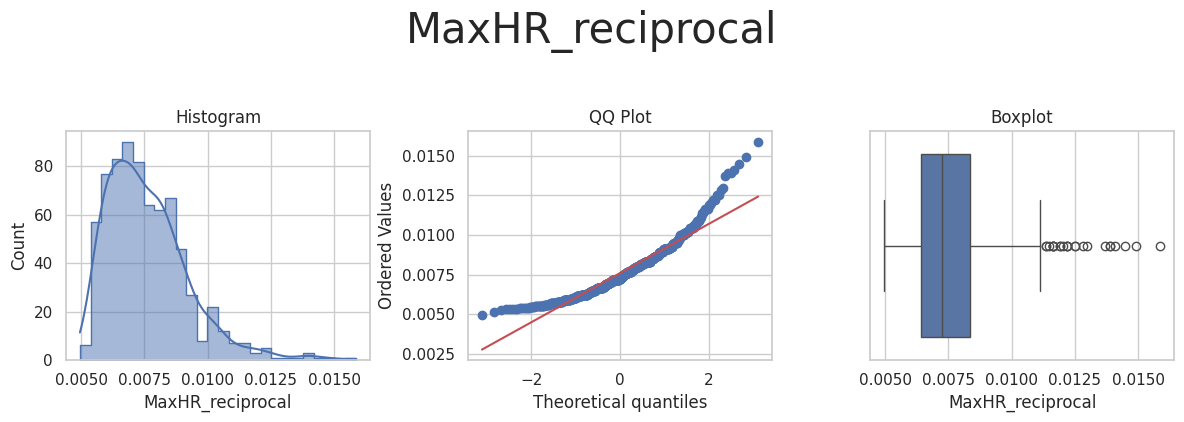

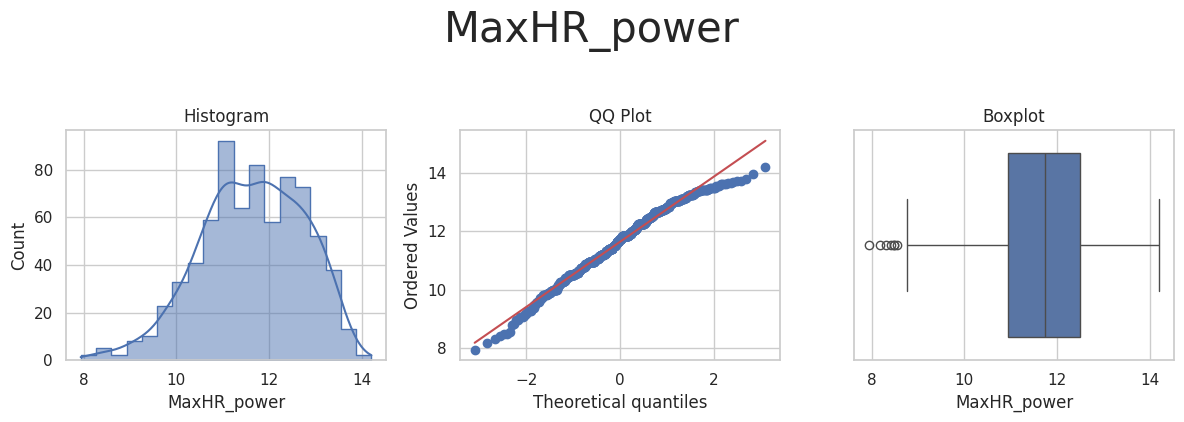

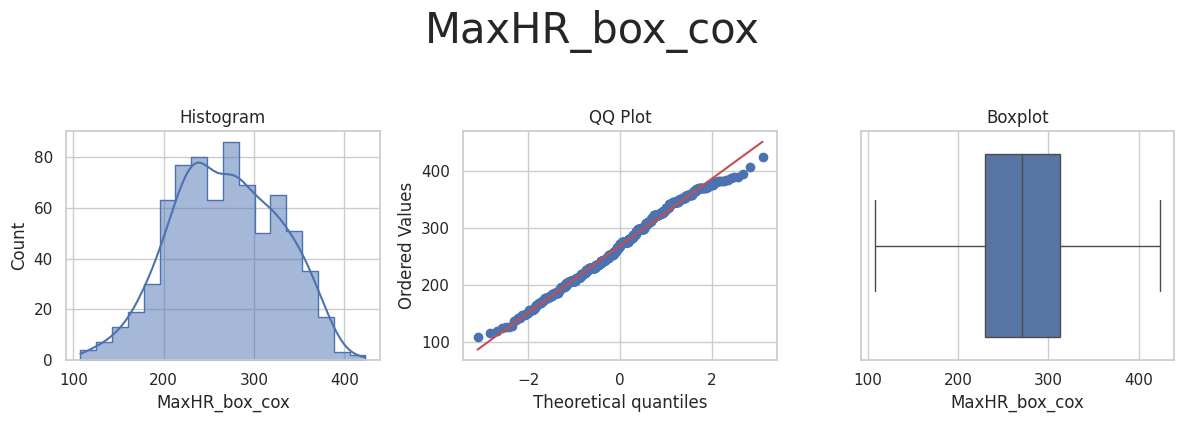

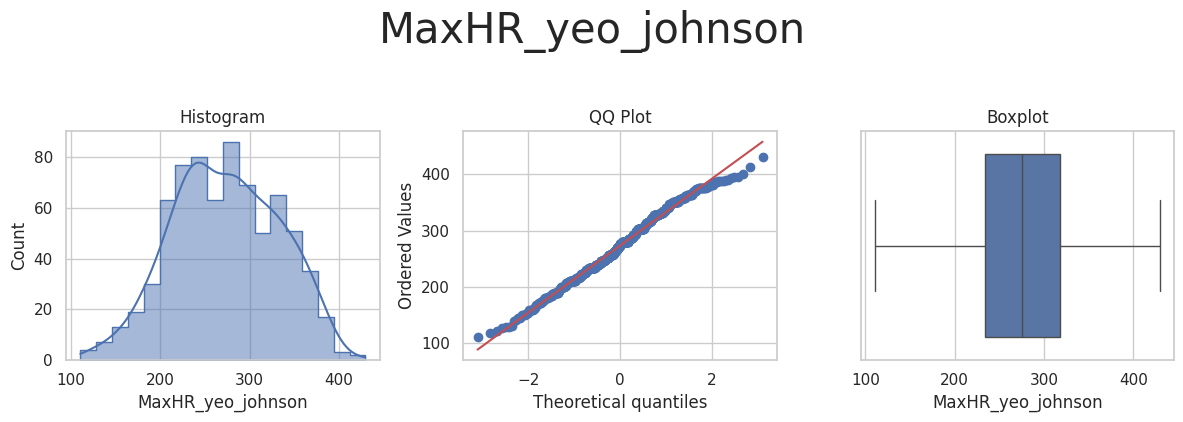

In [16]:
df_engineering = train_set_df[numerical_variables].copy()
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type="numerical")

From look at the analysis, it does not appear that any of the applied transformations have any significant effect on the distributions of the features.

Therefore, it was decided to continue without any numerical transformations, with the aim to revisit if the model performance is lower than required.

### SmartCorrelatedSelection Variables

We want to remove any surplus correlated features from the dataset to streamline the model and improve performance.

In [31]:
from feature_engine.selection import SmartCorrelatedSelection

df_engineering = train_set_df.drop("HeartDisease", axis=1).copy()

spearman_corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")
spearman_corr_sel.fit_transform(df_engineering)
spearman_corr_sel.correlated_feature_sets_

[]

In [29]:
df_engineering = train_set_df.drop("HeartDisease", axis=1).copy()

pearson_corr_sel = SmartCorrelatedSelection(variables=None, method="pearson", threshold=0.6, selection_method="variance")
pearson_corr_sel.fit_transform(df_engineering)
pearson_corr_sel.correlated_feature_sets_

[]

Neither methods found significant correlation between groups of features, so no features were selected to be dropped.

---

## Conclusions

Feature engineering was examined for all features within the dataset and the following conclusions were made:

* The 'Oldpeak' feature was required to be discretised
* Ordinal encoding was carried out on all categorical features ('Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope')
* Numerical transformations were found to have no significant effect on distributions
* No features were required to be dropped after analysis using the SmartCorrelatedSelection function

The discretisation and ordinal encoding steps will be added to the ML pipeline.